<a href="https://colab.research.google.com/github/motoroko/OCR-Aksara-Lontara/blob/main/OCR_Aksara_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set the matplotlib backend so figures can be saved in the background
%matplotlib inline
import matplotlib.pyplot as plt

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import build_montages
from imutils.contours import sort_contours
import imutils
import h5py

import numpy as np
import argparse
import cv2
import seaborn as sn

import os
from google.colab.patches import cv2_imshow

# Dataset

In [ ]:
main_folder = 'drive/MyDrive/Aksara_Lontara/dataset'

In [ ]:
os.listdir(main_folder)

['train', 'val', 'pred']

In [ ]:
print('Jumlah Karakter :',np.array(os.listdir(main_folder + '/train')).shape[0], 'karakter')
print('Karakter terdaftar :')
print(os.listdir(main_folder + '/train'))

Jumlah Karakter : 23 karakter
Karakter terdaftar :
['ka', 'ba', 'ga', 'ja', 'ca', 'la', 'ha', 'da', 'a', 'ma', 'nra', 'nya', 'ra', 'nga', 'pa', 'mpa', 'nca', 'ngka', 'na', 'sa', 'ta', 'wa', 'ya']


In [ ]:
# Function to check if two rectangles overlap or are close to each other
def is_close(rect1, rect2, threshold=50):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    # Calculate the center of each rectangle
    center1 = (x1 + w1 // 2, y1 + h1 // 2)
    center2 = (x2 + w2 // 2, y2 + h2 // 2)
    # Calculate the distance between the centers of the rectangles
    distance = ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5
    # Return True if the distance is less than the threshold
    return distance < threshold

def take(image):
  # Load the input image from disk, convert it to grayscale, and blur
  # it to reduce noise
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # Perform edge detection, find contours in the edge map, and sort the
  # resulting contours from left-to-right
  edged = cv2.Canny(blurred, 30, 150)
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sort_contours(cnts, method="left-to-right")[0]
  # Initialize the list of contour bounding boxes and associated
  # characters that we'll be OCR'ing
  chars = []

  # Loop over the contours
  for c in cnts:
      # Compute the bounding box of the contour
      (x, y, w, h) = cv2.boundingRect(c)
      # Filter out bounding boxes, ensuring they are neither too small
      # nor too large
      if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
          # Extract the character and threshold it to make the character
          # appear as *white* (foreground) on a *black* background, then
          # grab the width and height of the thresholded image
          roi = gray[y:y + h, x:x + w]
          thresh = cv2.threshold(roi, 0, 255,
              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
          (tH, tW) = thresh.shape
          # If the width is greater than the height, resize along the
          # width dimension
          if tW > tH:
              thresh = imutils.resize(thresh, width=64)
          # Otherwise, resize along the height
          else:
              thresh = imutils.resize(thresh, height=64)

          # Re-grab the image dimensions (now that its been resized)
          # and then determine how much we need to pad the width and
          # height such that our image will be 32x32
          (tH, tW) = thresh.shape
          dX = int(max(0, 64 - tW) / 2.0)
          dY = int(max(0, 64 - tH) / 2.0)
          # Pad the image and force 32x32 dimensions
          padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
              left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
              value=(0, 0, 0))
          padded = cv2.resize(padded, (64, 64))
          # Prepare the padded image for classification via our
          # handwriting OCR model
          padded = padded.astype("float32")# / 255.0
          padded = np.expand_dims(padded, axis=-1)
          # Update our list of characters that will be OCR'd
          chars.append((padded, (x, y, w, h)))

  # Extract the bounding box locations and padded characters
  boxes = [b[1] for b in chars]
  new_boxes = []
  # Loop over the bounding boxes
  for i in range(len(boxes)):
      # Check if the current bounding box is already merged
      if boxes[i] is None:
          continue
      x, y, w, h = boxes[i]
      # Loop over the remaining bounding boxes to check for merging candidates
      for j in range(i + 1, len(boxes)):
          # Check if the bounding box at index j is not None
          if boxes[j] is not None:
              x2, y2, w2, h2 = boxes[j]
              # Check if the current bounding box is already merged
              if (x2, y2, w2, h2) is None:
                  continue
              # Check if the current bounding box overlaps or is close to the other bounding box
              if is_close((x, y, w, h), (x2, y2, w2, h2)):
                  # Merge the two bounding boxes
                  x = min(x, x2)
                  y = min(y, y2)
                  w = max(x + w, x2 + w2) - x
                  h = max(y + h, y2 + h2) - y
                  # Mark the merged bounding boxes as None
                  boxes[j] = None
      new_boxes.append((x, y, w, h))

  chars = []
  for i in range(len(new_boxes)):
    # Check if the current bounding box is already merged
    if new_boxes[i] is None:
      continue
    x, y, w, h = new_boxes[i]
    roi = gray[y:y + h, x:x + w]
    thresh = cv2.threshold(roi, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    (tH, tW) = thresh.shape
    # if the width is greater than the height, resize along the
    # width dimension
    if tW > tH:
      thresh = imutils.resize(thresh, width=64)
    # otherwise, resize along the height
    else:
      thresh = imutils.resize(thresh, height=64)

    # re-grab the image dimensions (now that its been resized)
    # and then determine how much we need to pad the width and
    # height such that our image will be 64x64
    (tH, tW) = thresh.shape
    dX = int(max(0, 64 - tW) / 2.0)
    dY = int(max(0, 64 - tH) / 2.0)
    # pad the image and force 64x64 dimensions
    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
    value=(0, 0, 0))
    padded = cv2.resize(padded, (64, 64))
    # prepare the padded image for classification via our
    # handwriting OCR model
    padded = padded.astype("float32")# / 255.0
    padded = np.expand_dims(padded, axis=-1)
    # update our list of characters that will be OCR'd
    #cv2_imshow(padded*255)
    chars.append((padded, (x, y, w, h)))

  # extract the bounding box locations and padded characters
  boxes = [b[1] for b in chars]
  chars = np.array([c[0] for c in chars], dtype="float32")

  return chars[0]


In [ ]:
# Data Train
train_data = []
train_label = []

for label in os.listdir(main_folder + '/train'):
  for image in os.listdir(main_folder + '/train/' + label):
    img = cv2.imread(main_folder + '/train/' + label + '/' + image)
    img = cv2.resize(take(img), (64, 64))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train_data.append(img)
    train_label.append(label)

train_data = np.array(train_data)#/255.).astype(np.uint8)
train_label = np.array(train_label)

In [ ]:
train_data.shape

(7452, 64, 64)

In [ ]:
# Data Validasi
val_data = []
val_label = []

for label in os.listdir(main_folder + '/val'):
  for image in os.listdir(main_folder + '/val/' + label):
    img = cv2.imread(main_folder + '/val/' + label + '/' + image)
    img = cv2.resize(take(img), (64, 64))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    val_data.append(img)
    val_label.append(label)

val_data = np.array(val_data)#/255.
val_label = np.array(val_label)

In [ ]:
val_data.shape

(3736, 64, 64)

Label 	: Jumlah
---------------
a  	: 324


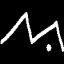


ba  	: 324


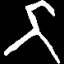


ca  	: 324


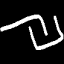


da  	: 324


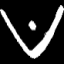


ga  	: 324


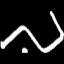


ha  	: 324


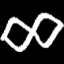


ja  	: 324


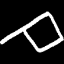


ka  	: 324


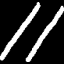


la  	: 324


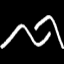


ma  	: 324


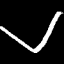


mpa  	: 324


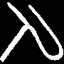


na  	: 324


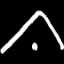


nca  	: 324


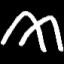


nga  	: 324


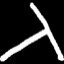


ngka  	: 324


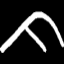


nra  	: 324


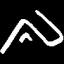


nya  	: 324


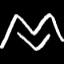


pa  	: 324


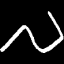


ra  	: 324


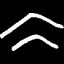


sa  	: 324


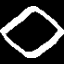


ta  	: 324


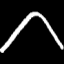


wa  	: 324


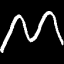


ya  	: 324


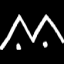

In [ ]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(train_label)
counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

print('Label \t: Jumlah')
print('---------------')
for i,lab in enumerate(le.classes_):
  print(lab,' \t:',counts[i])
  cv2_imshow(train_data[np.argwhere(train_label == lab)[0][0]])
  print()

In [ ]:
dummy2 = np.concatenate([train_data,val_data])
dummy2_label = np.concatenate([le.transform(train_label),le.transform(val_label)])

(trainX, testX, trainY, testY) = train_test_split(dummy2,
	dummy2_label, test_size=0.3333, stratify=dummy2_label, random_state=42)

trainX = np.expand_dims(trainX, axis=-1)
#trainY = np.expand_dims(trainY, axis=-1)
testX = np.expand_dims(testX, axis=-1)
#testY = np.expand_dims(testY, axis=-1)

In [ ]:
datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #horizontal_flip=True,
    validation_split=0.33
)

datagen.fit(np.expand_dims(dummy2, axis=-1))
#datagen = datagen.repeat()

# Main Model

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-1
BS = 32

In [ ]:
train_data.shape

(7452, 64, 64)

## VGG16

In [ ]:
clear_session()

vgg16_model = VGG16(weights=None, include_top=False, input_shape=(train_data.shape[1],train_data.shape[2],1))
vgg16_model.trainable=True

model = Sequential()
model.add(vgg16_model)
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(23, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14713536  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 400)               819600    
                                                                 
 dense_1 (Dense)             (None, 100)               40100     
                                                                 
 dense_2 (Dense)             (None, 23)                2323      
                                                                 
Total params: 15575559 (59.42 MB)
Trainable params: 15575559 (59.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


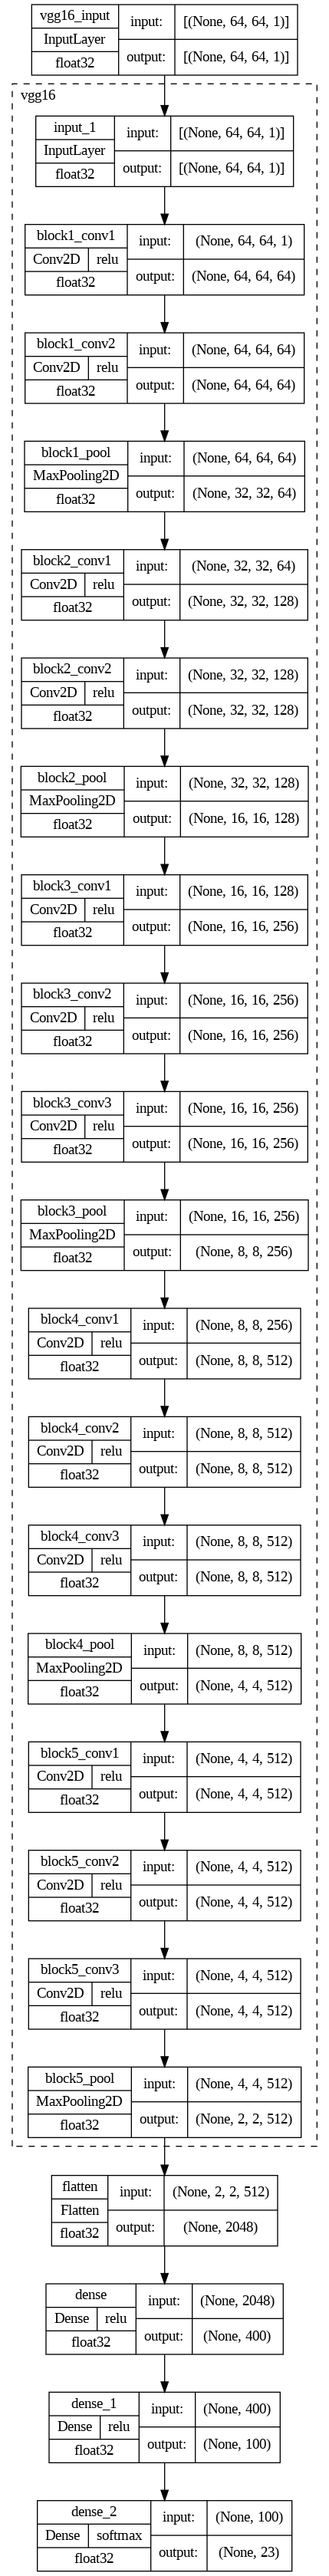

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)

In [ ]:
H = model.fit(
    datagen.flow(trainX, trainY,
                 batch_size=BS,subset='training'),
    validation_data = datagen.flow(testX, testY,
                                 batch_size=BS, subset='validation'),
    epochs=100,
    verbose=2
)

Epoch 1/100
157/157 - 14s - loss: 2.1255 - accuracy: 0.3305 - val_loss: 0.7799 - val_accuracy: 0.7138 - 14s/epoch - 86ms/step
Epoch 2/100
157/157 - 9s - loss: 0.5140 - accuracy: 0.8259 - val_loss: 0.2318 - val_accuracy: 0.9252 - 9s/epoch - 58ms/step
Epoch 3/100
157/157 - 9s - loss: 0.1703 - accuracy: 0.9430 - val_loss: 0.2006 - val_accuracy: 0.9333 - 9s/epoch - 60ms/step
Epoch 4/100
157/157 - 9s - loss: 0.1235 - accuracy: 0.9646 - val_loss: 0.0430 - val_accuracy: 0.9870 - 9s/epoch - 57ms/step
Epoch 5/100
157/157 - 9s - loss: 0.0734 - accuracy: 0.9786 - val_loss: 0.0983 - val_accuracy: 0.9764 - 9s/epoch - 59ms/step
Epoch 6/100
157/157 - 9s - loss: 0.0729 - accuracy: 0.9812 - val_loss: 0.0347 - val_accuracy: 0.9911 - 9s/epoch - 60ms/step
Epoch 7/100
157/157 - 9s - loss: 0.0529 - accuracy: 0.9848 - val_loss: 0.0426 - val_accuracy: 0.9862 - 9s/epoch - 55ms/step
Epoch 8/100
157/157 - 10s - loss: 0.0491 - accuracy: 0.9856 - val_loss: 0.0857 - val_accuracy: 0.9756 - 10s/epoch - 61ms/step
Epoc

In [ ]:
# H = model.fit(
#   np.array(trainX),
#   le.transform(trainY),
# 	validation_data=(np.array(testX), le.transform(testY)),
#   batch_size = BS,
# 	steps_per_epoch=len(trainX) // BS,
# 	epochs=100,
# 	verbose=2
# )

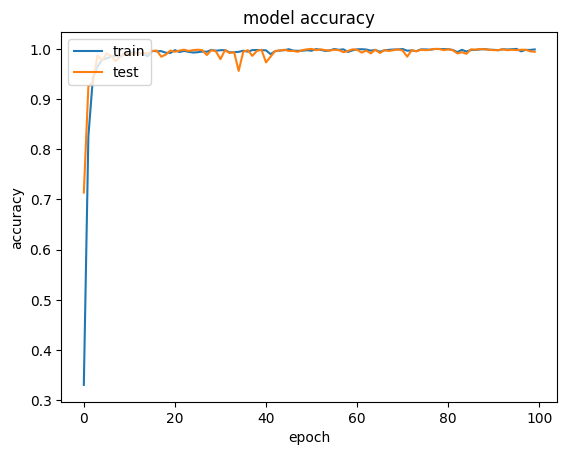

In [ ]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

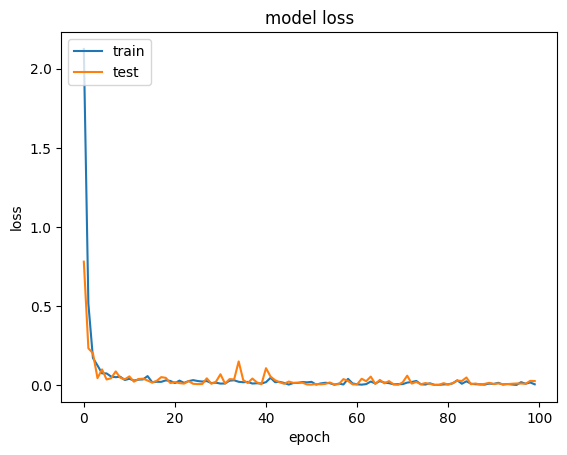

In [ ]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))

[INFO] evaluating network...
117/117 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

           a       1.00      1.00      1.00       162
          ba       1.00      0.99      1.00       162
          ca       1.00      1.00      1.00       162
          da       1.00      1.00      1.00       165
          ga       1.00      0.99      0.99       162
          ha       1.00      1.00      1.00       162
          ja       1.00      1.00      1.00       162
          ka       1.00      1.00      1.00       162
          la       1.00      1.00      1.00       162
          ma       1.00      1.00      1.00       162
         mpa       0.99      1.00      1.00       162
          na       1.00      1.00      1.00       162
         nca       1.00      1.00      1.00       162
         nga       1.00      1.00      1.00       162
        ngka       1.00      1.00      1.00       162
         nra       0.99      1.00      0.99       

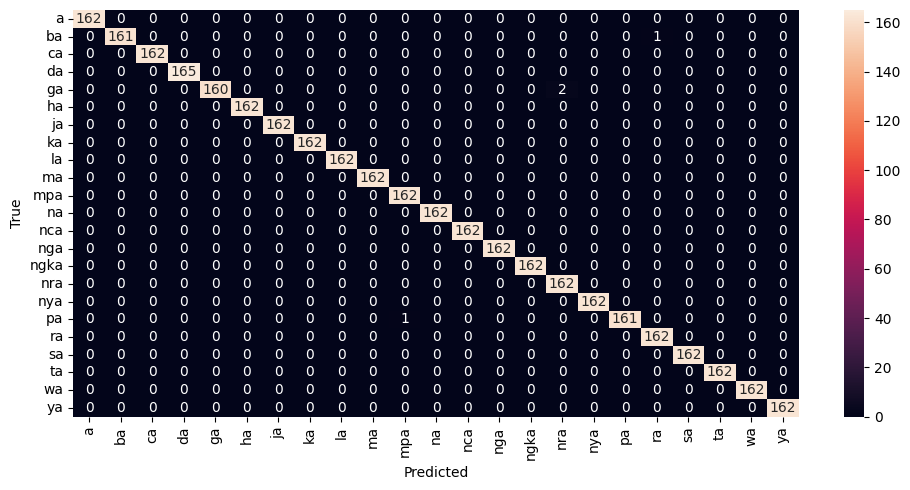

In [ ]:
plt.figure(figsize=(10,5))

sn.heatmap(
    confusion_matrix(
        testY.argmax(axis=1),predictions.argmax(axis=1)
        ),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    annot=True, fmt='d'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Saving Model

model.save('drive/MyDrive/Aksara_Lontara/model/vgg16_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## VGG19

In [ ]:
clear_session()

vgg19_model = VGG19(weights=None, include_top=False, input_shape=(train_data.shape[1],train_data.shape[2],1))
vgg19_model.trainable=True

model = Sequential()
model.add(vgg19_model)
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(23, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20023232  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 400)               819600    
                                                                 
 dense_1 (Dense)             (None, 100)               40100     
                                                                 
 dense_2 (Dense)             (None, 23)                2323      
                                                                 
Total params: 20885255 (79.67 MB)
Trainable params: 20885255 (79.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


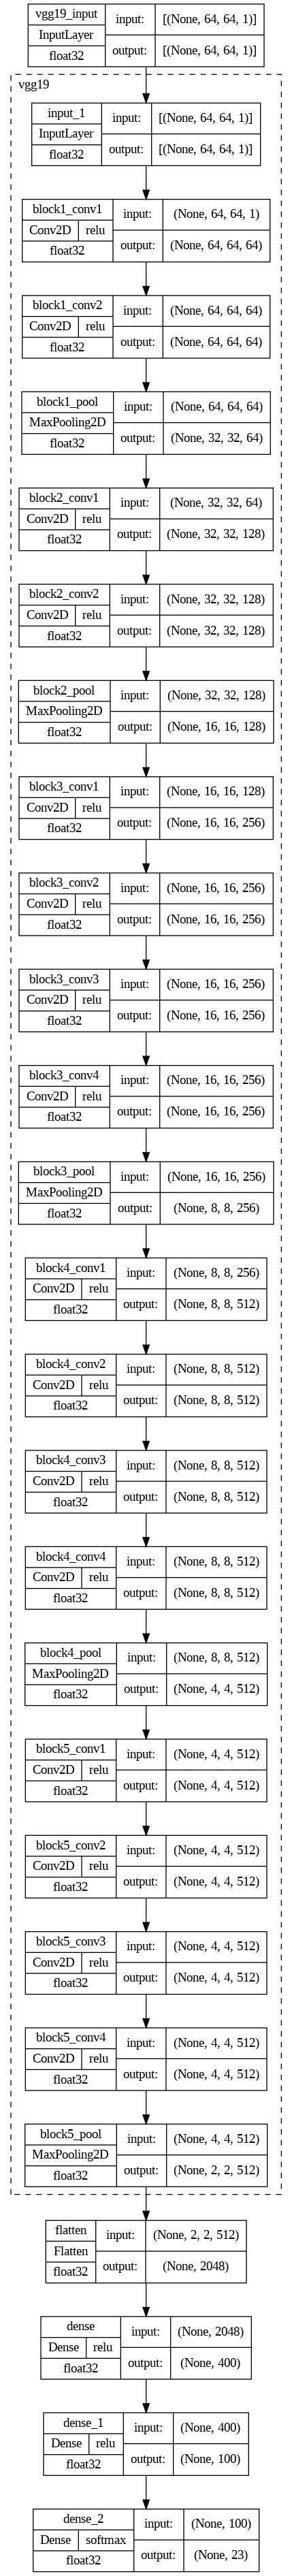

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)

In [ ]:
H = model.fit(
    datagen.flow(trainX, trainY,
                 batch_size=BS,subset='training'),
    validation_data = datagen.flow(testX, testY,
                                 batch_size=BS//2, subset='validation'),
    epochs=100,
    verbose=2
)

Epoch 1/100
157/157 - 17s - loss: 2.3014 - accuracy: 0.2679 - val_loss: 0.8750 - val_accuracy: 0.7033 - 17s/epoch - 111ms/step
Epoch 2/100
157/157 - 11s - loss: 0.6969 - accuracy: 0.7629 - val_loss: 0.2781 - val_accuracy: 0.9098 - 11s/epoch - 73ms/step
Epoch 3/100
157/157 - 13s - loss: 0.2934 - accuracy: 0.9076 - val_loss: 0.2772 - val_accuracy: 0.9236 - 13s/epoch - 84ms/step
Epoch 4/100
157/157 - 11s - loss: 0.1958 - accuracy: 0.9378 - val_loss: 0.1592 - val_accuracy: 0.9520 - 11s/epoch - 70ms/step
Epoch 5/100
157/157 - 11s - loss: 0.1307 - accuracy: 0.9582 - val_loss: 0.0846 - val_accuracy: 0.9780 - 11s/epoch - 71ms/step
Epoch 6/100
157/157 - 13s - loss: 0.1184 - accuracy: 0.9634 - val_loss: 0.2569 - val_accuracy: 0.9325 - 13s/epoch - 81ms/step
Epoch 7/100
157/157 - 11s - loss: 0.0935 - accuracy: 0.9746 - val_loss: 0.0982 - val_accuracy: 0.9740 - 11s/epoch - 72ms/step
Epoch 8/100
157/157 - 11s - loss: 0.0689 - accuracy: 0.9794 - val_loss: 0.0645 - val_accuracy: 0.9797 - 11s/epoch - 7

In [ ]:
# H = model.fit(
#   np.array(trainX),
#   le.transform(trainY),
# 	validation_data=(np.array(testX), le.transform(testY)),
#   batch_size = BS,
# 	steps_per_epoch=len(trainX) // BS,
# 	epochs=100,
# 	verbose=2
# )

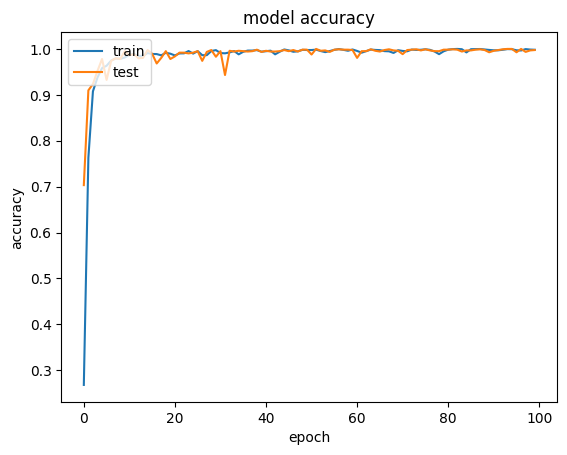

In [ ]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

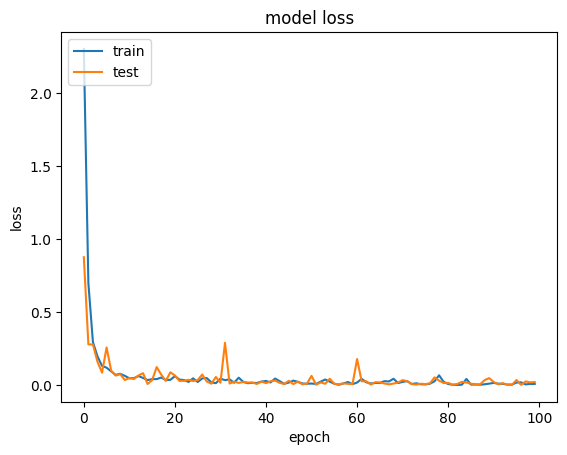

In [ ]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(testX)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_, digits=4))

[INFO] evaluating network...
117/117 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000       162
          ba     0.9877    0.9938    0.9908       162
          ca     1.0000    1.0000    1.0000       162
          da     1.0000    1.0000    1.0000       165
          ga     1.0000    1.0000    1.0000       162
          ha     1.0000    1.0000    1.0000       162
          ja     1.0000    1.0000    1.0000       162
          ka     1.0000    1.0000    1.0000       162
          la     1.0000    1.0000    1.0000       162
          ma     1.0000    1.0000    1.0000       162
         mpa     1.0000    0.9877    0.9938       162
          na     1.0000    1.0000    1.0000       162
         nca     1.0000    1.0000    1.0000       162
         nga     1.0000    1.0000    1.0000       162
        ngka     1.0000    1.0000    1.0000       162
         nra     1.0000    1.0000    1.0000       

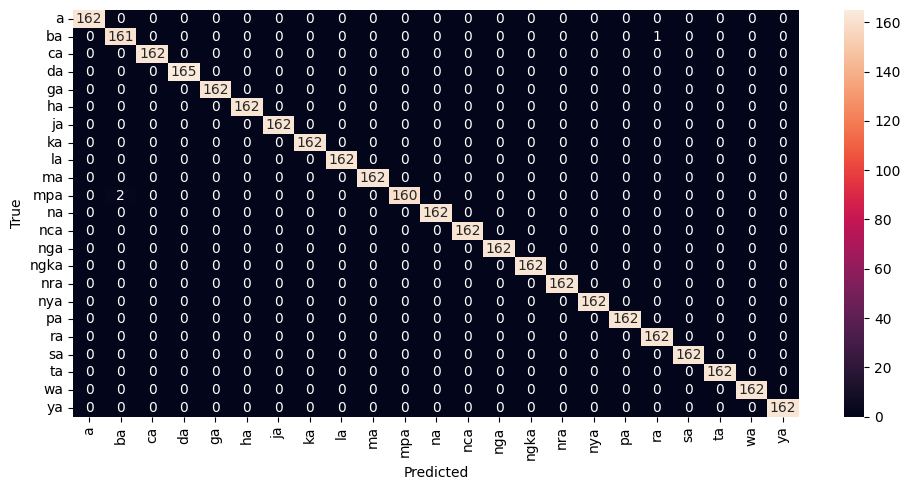

In [ ]:
plt.figure(figsize=(10,5))

sn.heatmap(
    confusion_matrix(
        testY.argmax(axis=1),predictions.argmax(axis=1)
        ),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    annot=True, fmt='d'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Saving Model

model.save('drive/MyDrive/Aksara_Lontara/model/vgg19_model.h5')

## ResNet

In [ ]:
clear_session()

RN_model = ResNet50(weights=None, include_top=False, input_shape=(train_data.shape[1],train_data.shape[2],1))
RN_model.trainable=True

model = Sequential()
model.add(RN_model)
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(23, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23581440  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 400)               3277200   
                                                                 
 dense_1 (Dense)             (None, 100)               40100     
                                                                 
 dense_2 (Dense)             (None, 23)                2323      
                                                                 
Total params: 26901063 (102.62 MB)
Trainable params: 26847943 (102.42 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


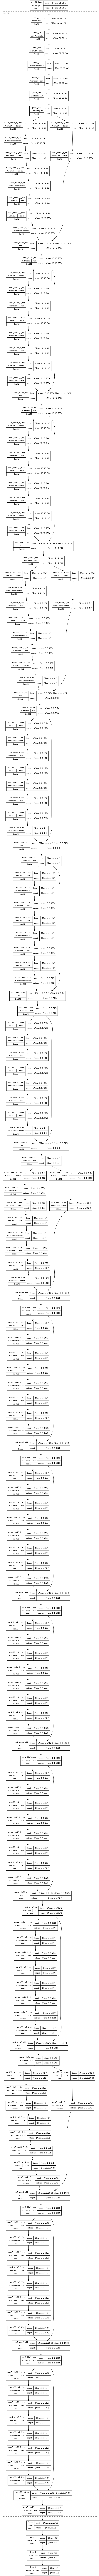

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)

In [ ]:
H = model.fit(
    datagen.flow(trainX, trainY,
                 batch_size=BS,subset='training'),
    validation_data = datagen.flow(testX, testY,
                                 batch_size=BS, subset='validation'),
    epochs=100,
    verbose=2
)

Epoch 1/100
157/157 - 47s - loss: 3.7600 - accuracy: 0.0694 - val_loss: 3.1215 - val_accuracy: 0.0764 - 47s/epoch - 302ms/step
Epoch 2/100
157/157 - 11s - loss: 2.9386 - accuracy: 0.0850 - val_loss: 3.1529 - val_accuracy: 0.0504 - 11s/epoch - 73ms/step
Epoch 3/100
157/157 - 11s - loss: 2.5988 - accuracy: 0.1625 - val_loss: 480.4572 - val_accuracy: 0.0463 - 11s/epoch - 70ms/step
Epoch 4/100
157/157 - 11s - loss: 2.1002 - accuracy: 0.2955 - val_loss: 1.7266 - val_accuracy: 0.4000 - 11s/epoch - 70ms/step
Epoch 5/100
157/157 - 11s - loss: 1.1228 - accuracy: 0.5964 - val_loss: 2.4536 - val_accuracy: 0.4667 - 11s/epoch - 69ms/step
Epoch 6/100
157/157 - 12s - loss: 0.6762 - accuracy: 0.7625 - val_loss: 0.5327 - val_accuracy: 0.8130 - 12s/epoch - 77ms/step
Epoch 7/100
157/157 - 10s - loss: 0.4310 - accuracy: 0.8633 - val_loss: 7.4713 - val_accuracy: 0.5041 - 10s/epoch - 66ms/step
Epoch 8/100
157/157 - 11s - loss: 0.3260 - accuracy: 0.9050 - val_loss: 1.2391 - val_accuracy: 0.8081 - 11s/epoch -

In [ ]:
# H = model.fit(
#   np.array(trainX),
#   le.transform(trainY),
# 	validation_data=(np.array(testX), le.transform(testY)),
#   batch_size = BS,
# 	steps_per_epoch=len(trainX) // BS,
# 	epochs=100,
# 	verbose=2
# )

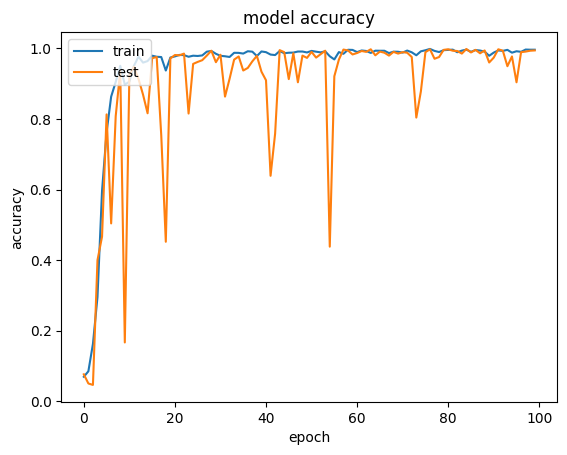

In [ ]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

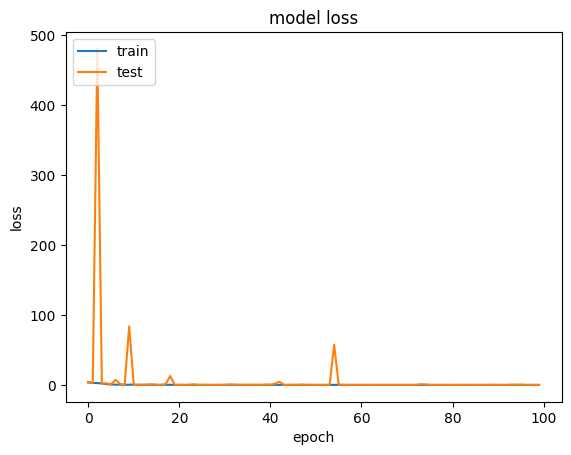

In [ ]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_, digits=4))

[INFO] evaluating network...
117/117 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

           a     0.9939    1.0000    0.9969       162
          ba     1.0000    1.0000    1.0000       162
          ca     1.0000    1.0000    1.0000       162
          da     1.0000    1.0000    1.0000       165
          ga     1.0000    1.0000    1.0000       162
          ha     1.0000    1.0000    1.0000       162
          ja     1.0000    1.0000    1.0000       162
          ka     1.0000    1.0000    1.0000       162
          la     1.0000    0.9938    0.9969       162
          ma     1.0000    1.0000    1.0000       162
         mpa     1.0000    1.0000    1.0000       162
          na     1.0000    1.0000    1.0000       162
         nca     1.0000    1.0000    1.0000       162
         nga     1.0000    1.0000    1.0000       162
        ngka     1.0000    1.0000    1.0000       162
         nra     1.0000    1.0000    1.0000       

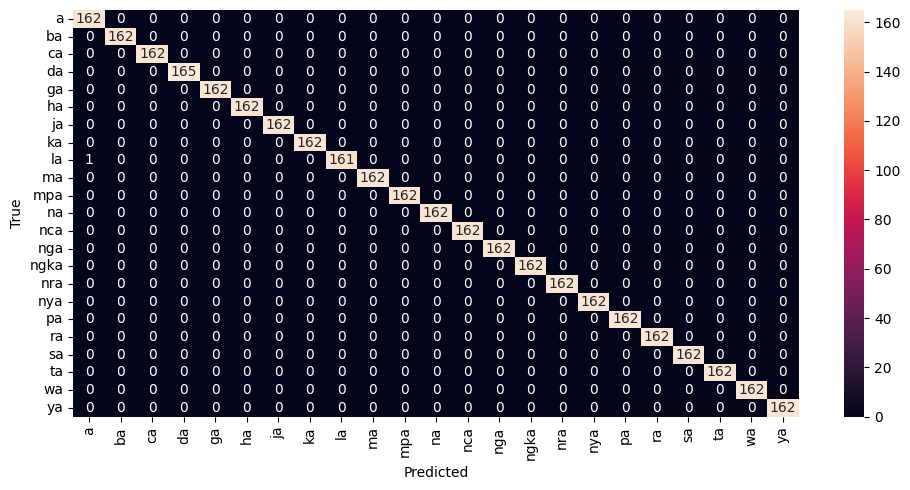

In [ ]:
plt.figure(figsize=(10,5))

sn.heatmap(
    confusion_matrix(
        testY.argmax(axis=1),predictions.argmax(axis=1)
        ),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    annot=True, fmt='d'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Saving Model

model.save('drive/MyDrive/Aksara_Lontara/model/resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## ResNetV2

In [ ]:
clear_session()

RNV2_model = ResNet50V2(weights=None, include_top=False, input_shape=(train_data.shape[1],train_data.shape[2],1))
RNV2_model.trainable=True

model = Sequential()
model.add(RNV2_model)
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(23, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23558528  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 400)               3277200   
                                                                 
 dense_1 (Dense)             (None, 100)               40100     
                                                                 
 dense_2 (Dense)             (None, 23)                2323      
                                                                 
Total params: 26878151 (102.53 MB)
Trainable params: 26832711 (102.36 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


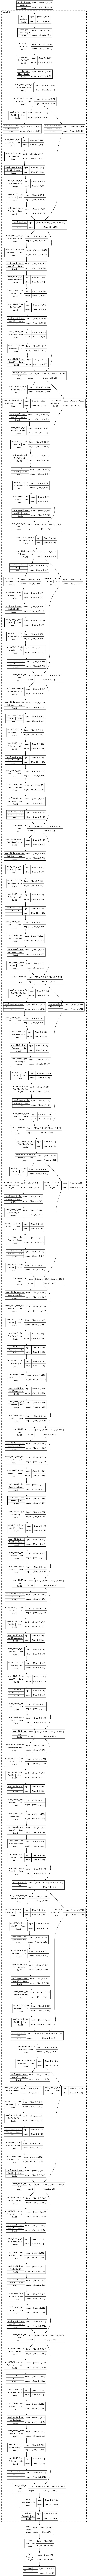

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False
)

In [ ]:
H = model.fit(
    datagen.flow(trainX, trainY,
                 batch_size=BS,subset='training'),
    validation_data = datagen.flow(testX, testY,
                                 batch_size=BS, subset='validation'),
    epochs=100,
    verbose=2
)

Epoch 1/100
157/157 - 44s - loss: 3.0001 - accuracy: 0.0882 - val_loss: 2.6362 - val_accuracy: 0.1260 - 44s/epoch - 283ms/step
Epoch 2/100
157/157 - 10s - loss: 2.1584 - accuracy: 0.2473 - val_loss: 26.3211 - val_accuracy: 0.0675 - 10s/epoch - 65ms/step
Epoch 3/100
157/157 - 10s - loss: 1.3339 - accuracy: 0.5050 - val_loss: 5.0666 - val_accuracy: 0.2512 - 10s/epoch - 64ms/step
Epoch 4/100
157/157 - 10s - loss: 0.8064 - accuracy: 0.7039 - val_loss: 5.3287 - val_accuracy: 0.4163 - 10s/epoch - 61ms/step
Epoch 5/100
157/157 - 10s - loss: 0.3629 - accuracy: 0.8850 - val_loss: 4.8543 - val_accuracy: 0.4301 - 10s/epoch - 64ms/step
Epoch 6/100
157/157 - 11s - loss: 0.4004 - accuracy: 0.8824 - val_loss: 0.3409 - val_accuracy: 0.9041 - 11s/epoch - 71ms/step
Epoch 7/100
157/157 - 10s - loss: 0.2061 - accuracy: 0.9366 - val_loss: 0.3811 - val_accuracy: 0.8878 - 10s/epoch - 61ms/step
Epoch 8/100
157/157 - 9s - loss: 0.1402 - accuracy: 0.9594 - val_loss: 0.1207 - val_accuracy: 0.9634 - 9s/epoch - 58

In [ ]:
# H = model.fit(
#   np.array(trainX),
#   le.transform(trainY),
# 	validation_data=(np.array(testX), le.transform(testY)),
#   batch_size = BS,
# 	steps_per_epoch=len(trainX) // BS,
# 	epochs=100,
# 	verbose=2
# )

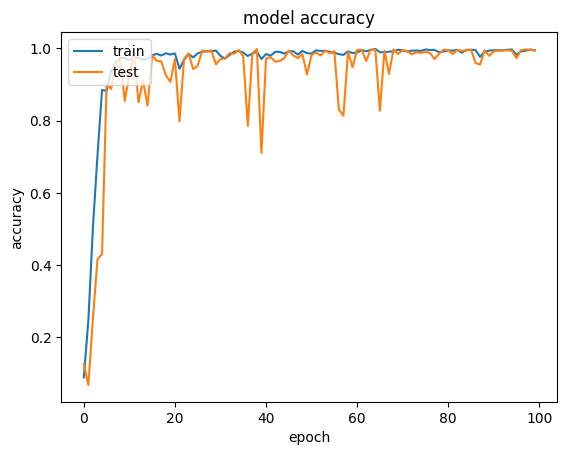

In [ ]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

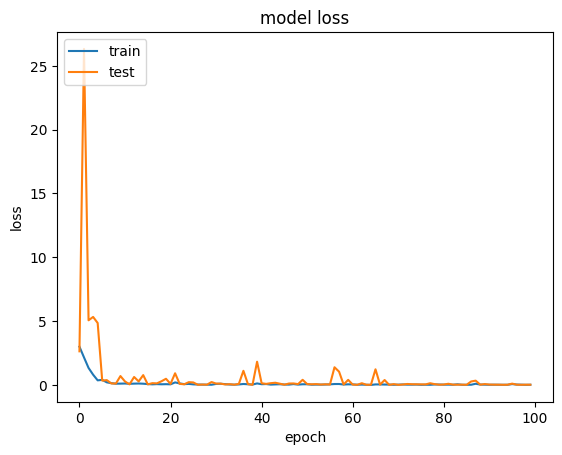

In [ ]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_, digits=4))

[INFO] evaluating network...
117/117 [==============================] - 2s 17ms/step
              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000       162
          ba     1.0000    1.0000    1.0000       162
          ca     1.0000    1.0000    1.0000       162
          da     1.0000    1.0000    1.0000       165
          ga     1.0000    1.0000    1.0000       162
          ha     1.0000    1.0000    1.0000       162
          ja     1.0000    1.0000    1.0000       162
          ka     1.0000    1.0000    1.0000       162
          la     1.0000    1.0000    1.0000       162
          ma     1.0000    1.0000    1.0000       162
         mpa     1.0000    1.0000    1.0000       162
          na     1.0000    1.0000    1.0000       162
         nca     1.0000    1.0000    1.0000       162
         nga     1.0000    1.0000    1.0000       162
        ngka     1.0000    1.0000    1.0000       162
         nra     1.0000    1.0000    1.0000       

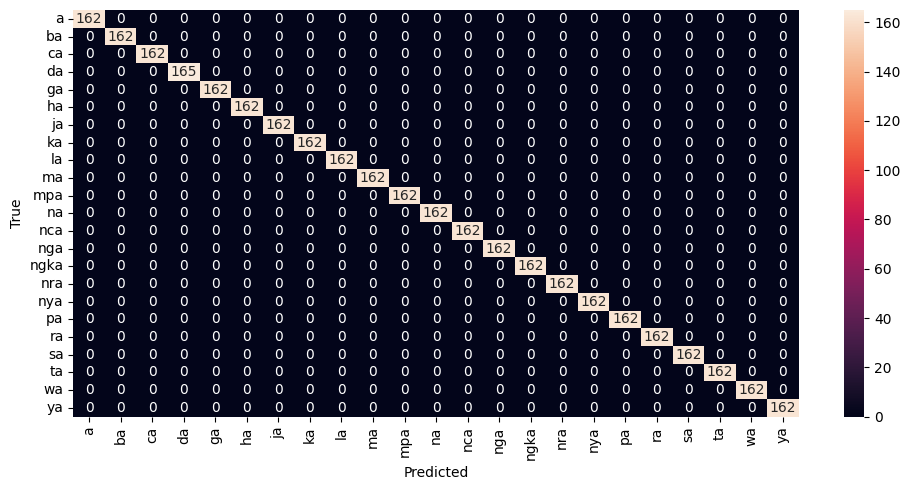

In [ ]:
plt.figure(figsize=(10,5))

sn.heatmap(
    confusion_matrix(
        testY.argmax(axis=1),predictions.argmax(axis=1)
        ),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    annot=True, fmt='d'
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
# Saving Model

model.save('drive/MyDrive/Aksara_Lontara/model/resnetv2_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
